In [1]:
#!pip install d2l
import torch
import random
from d2l import torch as d2l

# 构造数据集
生成一个包含1000个样本的数据集,每个样本包含从 standard normal distribution 中采样的2个特征
数据集为矩阵:
$$\mathbf{X} \in \mathbb{R}^{1000*2}$$
模型为
$$\mathbf{y} = \mathbf{Xw}+b+ϵ$$
模型参数 $\mathbf{w} = [2, -3.4]^{\top}, b = 4.2$

In [21]:
def synthetic_data(w, b, num_examples):
  X = torch.normal(0, 1, (num_examples, len(w)))
  # X's shape is (1000, 2)
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape(-1, 1) # 标量 -> 向量

In [22]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [23]:
labels.shape

torch.Size([1000, 1])

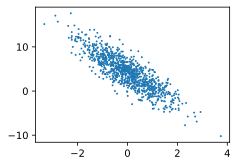

In [28]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(), 1)

# 读取数据集

In [40]:
# 打乱数据集, 小批量获取
def data_iter(batch_size, features, labels):
  num_examples = len(features) #1000
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i+batch_size, num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]

In [50]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[ 1.3049, -0.4945],
        [-1.6132, -0.4637],
        [ 0.2183, -1.6855],
        [ 0.4436, -0.0314],
        [-1.1163,  0.3185],
        [-0.4928, -0.0727],
        [ 0.0995, -0.0180],
        [ 0.0114,  0.2692],
        [ 0.5284,  1.4269],
        [-2.4745, -0.5959]]) 
 tensor([[ 8.5030],
        [ 2.5620],
        [10.3623],
        [ 5.1965],
        [ 0.8771],
        [ 3.4431],
        [ 4.4489],
        [ 3.2862],
        [ 0.4145],
        [ 1.2907]])


# 初始化权重和偏置
任务为更新这些参数, 直到参数足够拟合数据

In [52]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 定义模型和 loss function

In [63]:
def linreg(X, w, b):
  return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
  return (y_hat - y.reshape(y_hat.shape))**2/2

# 定义优化算法
使用 SGD 算法更新参数, 每一步更新的大学由学习率决定

用批量大小(batch_size)来规范化步⻓，这样步⻓大小就不会取决于我们对批量大小的选择

In [69]:
def sgd(params, lr, batch_size):
  with torch.no_grad(): # don't record grad, 此函数只负责更新param
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_() # set grad to 0

# 训练
步骤:
- 每次迭代读取小批量训练样本
- 通过模型或得一组预测
- 计算损失
- 反向传播, 储存每个参数的梯度
- 调用优化算法来更新模型参数

概括
- 初始化参数
- 重复一下训练直到完成
  - 计算梯度 ($\nabla$) $$
\mathbf{g} \leftarrow \partial_{(\mathbf{w}, b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l\left(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b\right)
$$
  - 更新参数$$
(\mathbf{w}, b) \leftarrow(\mathbf{w}, b)-\eta \mathbf{g}
$$

In [70]:
lr = 0.03
num_epochs = 3 # 迭代周期个数
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y) # X 和 y 的小批量损失
    # l 的形状是(batch_size, 1), 而不是一个标量
    # 所以l中的所有元素被加到一起(也就是乘单位向量, 对梯度无影响)
    # 以此计算[w, b]的梯度
    l.sum().backward()
    sgd([w,b], lr, batch_size) # 更新参数
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000054
epoch 2, loss 0.000054
epoch 3, loss 0.000054


In [68]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}') 
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0007,  0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


tensor([4.1994], requires_grad=True)